In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import scipy.ndimage
from scipy import stats

import tensorflow as tf
from tensorflow import keras    
from keras.models import Model
from keras import backend as K

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:

def G_rate_map(arena_size=[50,50], theta=0., phase=[50,50], lamb=500):
    '''
    Grid cells activity maps as presented in:
    - Blair et al. (2007), equation (1)
    - Almeida et al. (2009), equation (1)
    Params:
        arena_size (tuple of int) : define rate_map dimensions
        theta (float)             : Grid rotation (assume to be either 0°, 20°, or 40°, in degrees)
        Phase (tuple of int)      : Spatial phase of the grid     
        lamb (int)                : Distance between firing fields
    '''

    G = np.zeros(arena_size)
    a = 0.3
    b = -3./2.        
    lambV = (4*np.pi)/(np.sqrt(3*lamb))
    theta = np.radians(theta)

    for ind, val in np.ndenumerate(G):

        tmp_g = 0
        for i in np.deg2rad(np.linspace(-30,90,3)):
            u_f = (np.cos(i+theta),np.sin(i+theta))
            dist = (ind[0]-phase[0],ind[1]-phase[1])
            tmp_g += np.cos( lambV * np.dot(u_f,dist) )
            
        tmp_g = np.exp(np.dot(a,(tmp_g)+b))-1
        G[ind] = tmp_g
        
    return G

In [4]:
G1 = G_rate_map(phase=[0,0])
G1 += abs(G1.min())
G2 = G_rate_map(phase=[25,25])
G2 += abs(G2.min())

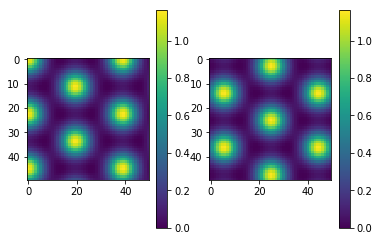

In [5]:
plt.subplot(1,2,1)
plt.imshow(G1)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(G2)
plt.colorbar()

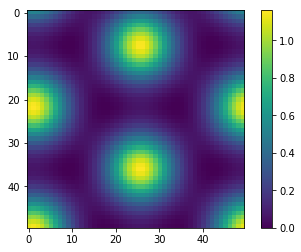

In [6]:
out_cell = G_rate_map( lamb=800)
out_cell += abs(out_cell.min())
plt.imshow(out_cell)
plt.colorbar()

In [7]:
out_cell = out_cell.flatten()

# Model

In [68]:
input_shape = 2  ## Number of grid cells 

model = keras.Sequential([
keras.layers.Dense(20, activation=tf.nn.relu, input_shape=(input_shape,)),
# keras.layers.Dense(50, activation=tf.nn.sigmoid),
# keras.layers.Softmax(),
keras.layers.Dense(10, activation=tf.nn.tanh),
keras.layers.Softmax(),
keras.layers.Dense(1)
])


optimizer = tf.train.RMSPropOptimizer(0.001)

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae'])

In [69]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_18 (Dense)             (None, 10)                210       
_________________________________________________________________
softmax_1 (Softmax)          (None, 10)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


In [70]:
in_data = np.vstack(  ( G1.flatten() , G2.flatten() ) ) 
in_data = in_data.T

In [71]:
idx = np.arange(in_data.shape[0])
np.random.shuffle(idx)

In [72]:
EPOCHS = 1000
history = model.fit( in_data[idx],  out_cell[idx], epochs=EPOCHS, validation_split=0.2, verbose=0)

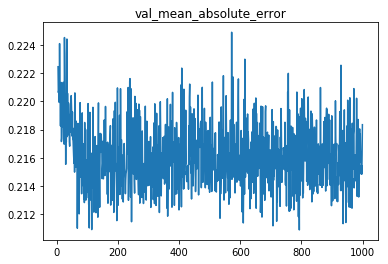

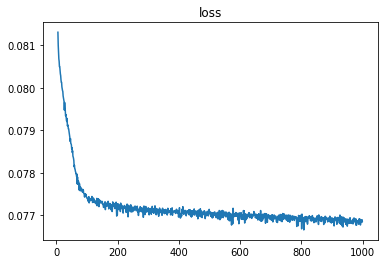

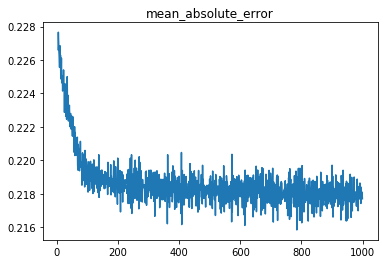

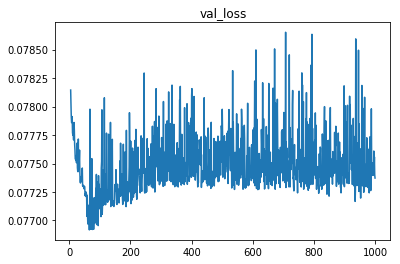

In [73]:
for kk in history.history.keys():
    plt.plot(  history.epoch[5:], history.history[kk][5:] )
    plt.title(kk)
    plt.show()

In [74]:
log = []
for ii in range(in_data.shape[0]):
    log.append( model.predict(   np.array([in_data[ii]]) )[0][0] )

In [75]:
log = np.array(log)

In [76]:
log = log.reshape(50,50)

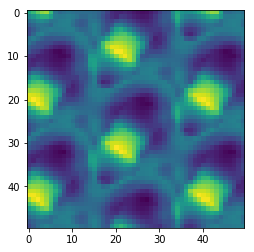

In [77]:
plt.imshow(log)